<a href="https://colab.research.google.com/github/Mark-Barbaric/Generative-Adversarial-Networks-GANs-Specialization/blob/course1_week4/week4/w4_build_controllable_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Controllable GAN

### Goals
In this notebook, you're going to implement a GAN controllability method using gradients from a classifier. By training a classifier to recognize a relevant feature, you can use it to change the generator's inputs (z-vectors) to make it generate images with more or less of that feature.

You will be started you off with a pre-trained generator and classifier, so that you can focus on the controllability aspects. However, in case you would like to train your own classifier, the code for that has been provided as well.

### Learning Objectives
1. Observe how controllability can change a generator's output.
2. Resolve some of the challenges that entangled features pose to controllability.

## Getting started!

You will start off by importing useful libraries and packages and defining a visualization function. You have also been provided with the generator, noise, and classifier code from earlier assignments. The classifier has the same archicture as the earlier critic (remember that the discriminator/critic is simply a classifier used to classify real and fake).

#### CelebA
For this notebook, instead of the MNIST dataset, you will be using [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). CelebA is a dataset of annotated celebrity images. Since they are colored (not black-and-white), the images have three channels for red, green, and blue (RGB).

![celeba](https://github.com/Mark-Barbaric/Generative-Adversarial-Networks-GANs-Specialization/blob/course1_week4/week4/celeba.png?raw=1)

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(0)

In [3]:
from google.colab import drive, files

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    """_summary_ Function for visualizing images
    Args:
        image_tensor (_type_): _description_
        num_images (int, optional): _description_. Defaults to 16.
        size (tuple, optional): _description_. Defaults to (3, 64, 64).
        nrows (int, optional): _description_. Defaults to 3.
    """
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[: num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Generator and Noise

In [24]:
class Generator(nn.Module):
    """_summary_

    Args:
        nn (_type_): _description_
    """
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_generator_block(z_dim, hidden_dim * 8),
            self.make_generator_block(hidden_dim * 8, hidden_dim * 4),
            self.make_generator_block(hidden_dim * 4, hidden_dim * 2),
            self.make_generator_block(hidden_dim * 2, hidden_dim),
            self.make_generator_block(hidden_dim, im_chan, kernel_size=4, final_layer=True)
        )


    def make_generator_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)


def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples in the batch, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)


### Classifier

In [47]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True)
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )

    def forward(self, image):
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

## Specifying Parameters
Before you begin training, you need to specify a few parameters:
  *   z_dim: the dimension of the noise vector
  *   batch_size: the number of images per forward/backward pass
  *   device: the device type

In [48]:
z_dim = 64
batch_size = 128
device = 'cuda'

## Train a Classifier (Optional)

You're welcome to train your own classifier with this code, but you are provided with a pretrained one later in the code. Feel free to skip this code block, and if you do want to train your own classifier, it is recommended that you initially go through the assignment with the provided classifier!

In [49]:
def train_classifier(filename):
    label_indices = range(40)
    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

#    dataloader = DataLoader(
#        CelebA('.', split='train', download=True, transform=transform),
#        batch_size=batch_size,
#        shuffle=True
#    )
    celeb_mnist_data_location = '/AI/data/mnist'

    dataloader = DataLoader(
        CelebA(celeb_mnist_data_location, split='train', download=False, transform=transform),
        batch_size=batch_size,
        shuffle=True
    )

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []

    for epoch in range(n_epochs):
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward()
            class_opt.step()
            classifier_losses.append(class_loss.item())

            if cur_step > 0 and cur_step % display_step == 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Epoch {epoch}, step {cur_step}, Classifier Loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label='Classifier Loss')
                plt.legend()
                plt.show()

            cur_step += 1



In [50]:
#train_classifier('classifier')

In [51]:
pretrained_model_loc = '/content/drive/MyDrive/AI/models/coursera/Generative_Adversarial_Networks/course_1/week_4'

In [52]:
gen = Generator(z_dim).to(device)
gen_dict = torch.load(f"{pretrained_model_loc}/pretrained_celeba.pth")['gen']
gen.load_state_dict(gen_dict)
gen.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [53]:
n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load(f"{pretrained_model_loc}/pretrained_classifier.pth", map_location=torch.device(device))['classifier']
classifier.load_state_dict(class_dict)
classifier.eval()


Classifier(
  (classifier): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 40, kernel_size=(4, 4), stride=(2, 2))
    )
  )
)

In [54]:
opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

## Training
Now you can start implementing a method for controlling your GAN!

#### Update Noise
For training, you need to write the code to update the noise to produce more of your desired feature. You do this by performing stochastic gradient ascent. You use stochastic gradient ascent to find the local maxima, as opposed to stochastic gradient descent which finds the local minima. Gradient ascent is gradient descent over the negative of the value being optimized. Their formulas are essentially the same, however, instead of subtracting the weighted value, stochastic gradient ascent adds it; it can be calculated by `new = old + (∇ old * weight)`, where ∇ is the gradient of `old`. You perform stochastic gradient ascent to try and maximize the amount of the feature you want. If you wanted to reduce the amount of the feature, you would perform gradient descent. However, in this assignment you are interested in maximize your feature using gradient ascent, since many features in the dataset are not present much more often than they're present and you are trying to add a feature to the images, not remove.

Given the noise with its gradient already calculated through the classifier, you want to return the new noise vector.

<details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">calculate_updated_noise</font></code></b>
</font>
</summary>

1.   Remember the equation for gradient ascent: `new = old + (∇ old * weight)`.

</details>

In [55]:
def calculate_updated_noise(noise, weight):
    new_noise = noise + (weight * noise.grad)
    return new_noise

In [56]:
opt.zero_grad()
noise = torch.ones(20, 20) * 2
noise.requires_grad_()
fake_classes = (noise ** 2).mean()
fake_classes.backward()
new_noise = calculate_updated_noise(noise, 0.1)
assert type(new_noise) == torch.Tensor
assert tuple(new_noise.shape) == (20, 20)
assert new_noise.max() == 2.0010
assert new_noise.min() == 2.0010
assert torch.isclose(new_noise.sum(), torch.tensor(0.4) + 20 * 20 * 2)
print("Success")

Success


In [57]:
opt.zero_grad()
noise = get_noise(32, z_dim).to(device).requires_grad_()
fake = gen(noise)
fake_classes = classifier(fake)[:, 0]
fake_classes.mean().backward()
noise.data = calculate_updated_noise(noise, 0.01)
fake = gen(noise)
fake_classes_new = classifier(fake)[:, 0]
assert torch.all(fake_classes_new > fake_classes)
print("Success")

Success


#### Generation
Now, you can use the classifier along with stochastic gradient ascent to make noise that generates more of a certain feature. In the code given to you here, you can generate smiling faces. Feel free to change the target index and control some of the other features in the list! You will notice that some features are easier to detect and control than others.

The list you have here are the features labeled in CelebA, which you used to train your classifier. If you wanted to control another feature, you would need to get data that is labeled with that feature and train a classifier on that feature.

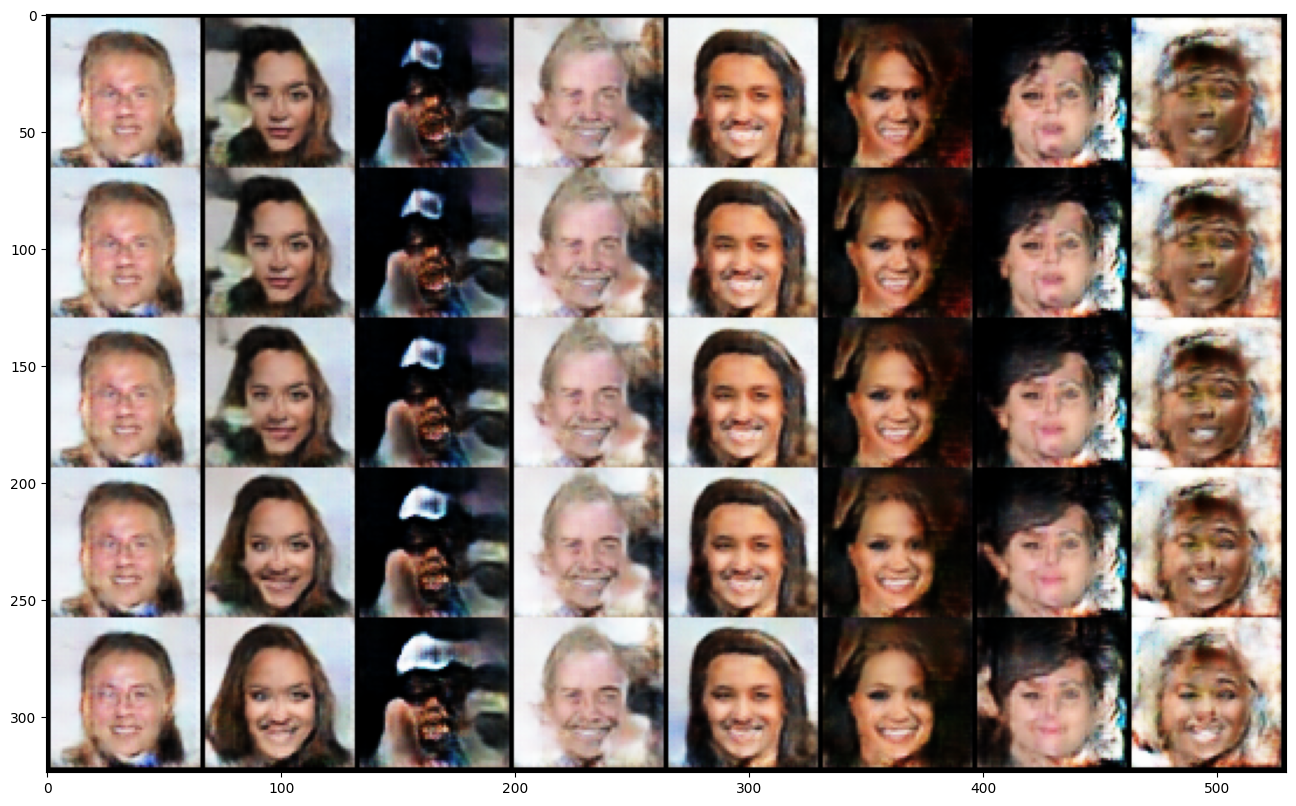

In [63]:
n_images = 8
fake_image_history = []
grad_steps = 10
skip = 2

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male",
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose",
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings",
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

target_indices = feature_names.index("Smiling")
noise = get_noise(n_images, z_dim).to(device)
noise.requires_grad_()

for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1.0 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)


## Entanglement and Regularization
You may also notice that sometimes more features than just the target feature change. This is because some features are entangled. To fix this, you can try to isolate the target feature more by holding the classes outside of the target class constant. One way you can implement this is by penalizing the differences from the original class with L2 regularization. This L2 regularization would apply a penalty for this difference using the L2 norm and this would just be an additional term on the loss function.

Here, you'll have to implement the score function: the higher, the better. The score is calculated by adding the target score and a penalty -- note that the penalty is meant to lower the score, so it should have a negative value.

For every non-target class, take the difference between the current noise and the old noise. The greater this value is, the more features outside the target have changed. You will calculate the magnitude of the change, take the mean, and negate it. Finally, add this penalty to the target score. The target score is the mean of the target class in the current noise.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">get_score</font></code></b>
</font>
</summary>

1.   The higher the score, the better!
2.   You want to calculate the loss per image, so you'll need to pass a dim argument to [`torch.norm`](https://pytorch.org/docs/stable/generated/torch.norm.html).
3.   Calculating the magnitude of the change requires you to take the norm of the difference between the classifications, not the difference of the norms.

</details>

In [ ]:
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    other_distances = None
    other_class_penalty = None
    target_score = None
    return target_score + other_class_penalty

In [ ]:
assert torch.isclose(
    get_score(torch.ones(4,3), torch.zeros(4, 3), [0], [1, 2], 0.2),
    1 - torch.sqrt(torch.tensor(2.)) * 2
)

rows = 10
current_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()
original_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows, [5] * rows]).T.float()

assert get_score(current_class, original_class, [1, 3], [0, 2], 0.2).item() == 3

current_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()
original_class = torch.tensor([[4] * rows, [4] * rows, [2] * rows, [1] * rows]).T.float()

assert torch.isclose(get_score(current_class, original_class, [1, 3] , [0, 2], 0.2),
                     -torch.sqrt(torch.tensor(10.0)) * 0.2 + 3)

In the following block of code, you will run the gradient ascent with this new score function. You might notice a few things after running it:

1.   It may fail more often at producing the target feature when compared to the original approach. This suggests that the model may not be able to generate an image that has the target feature without changing the other features. This makes sense! For example, it may not be able to generate a face that's smiling but whose mouth is NOT slightly open. This may also expose a limitation of the generator.
Alternatively, even if the generator can produce an image with the intended features, it might require many intermediate changes to get there and may get stuck in a local minimum.

2.   This process may change features which the classifier was not trained to recognize since there is no way to penalize them with this method. Whether it's possible to train models to avoid changing unsupervised features is an open question.